# Исследование поведения пользователей в приложении

## Описание проекта

Мы работаем в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи нашего мобильного приложения. Изучив воронку событий, узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуем результаты A/ A/ B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/ A/ B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, мы можем быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также поможет понять, сколько времени и данных потребуется для дальнейших тестов.

`EventName` — название события;    
`DeviceIDHash` — уникальный идентификатор пользователя;    
`EventTimestamp` — время события;    
`ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.     

# Импорт библиотек

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objects as go 
import numpy as np
from scipy import stats as st
import math as mth

plt.style.use('bmh')

# Подготовка данных к анализу

In [2]:
data = pd.read_csv('logs_exp.csv', sep = '\t')

In [3]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


(244126, 4)

In [5]:
# наличие пропусков
print(data.isna().sum())

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64


In [6]:
print('Найдено дубликатов:', data.duplicated().sum(),',' ,'что составляет', round((data.duplicated().sum() / data.shape[0])*100, 2), '% .')

Найдено дубликатов: 413 , что составляет 0.17 % .


## Удаление дубликатов

In [7]:
## удаляем дубли
data = data.drop_duplicates()

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
EventName         243713 non-null object
DeviceIDHash      243713 non-null int64
EventTimestamp    243713 non-null int64
ExpId             243713 non-null int64
dtypes: int64(3), object(1)
memory usage: 9.3+ MB


## Корреткировка формата времени

In [9]:
# корректировка формата времени из unix формата
data['EventTimestamp'] = data['EventTimestamp'].astype('datetime64[s]')
data['date'] = data['EventTimestamp'].dt.date
data['time'] = data['EventTimestamp'].dt.time
data['date'] = pd.to_datetime(data.date)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
EventName         243713 non-null object
DeviceIDHash      243713 non-null int64
EventTimestamp    243713 non-null datetime64[ns]
ExpId             243713 non-null int64
date              243713 non-null datetime64[ns]
time              243713 non-null object
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 13.0+ MB


## Статистические данные

In [11]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
DeviceIDHash,243713.0,4.627963e+18,2.642723e+18,6.888747e+15,2.372212e+18,4.623192e+18,6.932517e+18,9.222603e+18
ExpId,243713.0,2.470222e+02,8.244199e-01,2.460000e+02,2.460000e+02,2.470000e+02,2.480000e+02,2.480000e+02


In [12]:
data.describe(include = 'object').T

,count,unique,top,freq
EventName,243713,5,MainScreenAppear,119101
time,243713,69824,12:29:55,19


**Вывод:**    
- размер таблицы 244126 на 4.
- дубликаты: 413 строк, удалены;
- пропуски: отсутствуют;
- формат времени сконвертирован;
- аномалии в данных: отсутствуют.

# Изучение и проверка данных

## Количество событий в логе

In [13]:
event_stat = data.groupby('EventName')['DeviceIDHash'].count().reset_index()
event_stat.columns = 'EventName', 'Amount'
event_stat.sort_values(by='Amount', ascending = False)

,EventName,Amount
1,MainScreenAppear,119101
2,OffersScreenAppear,46808
0,CartScreenAppear,42668
3,PaymentScreenSuccessful,34118
4,Tutorial,1018


## Количество событий пользователей в логе    

In [14]:
print('Всего пользователей в логе',data['DeviceIDHash'].nunique())

Всего пользователей в логе 7551


## Количество событий в среднем на пользователя  

In [15]:
mean_event_per_user = data.groupby('DeviceIDHash')['EventName'].count().mean()
f'В среднем на одного пользователя приходится {mean_event_per_user:.0f} события'

'В среднем на одного пользователя приходится 32 события'

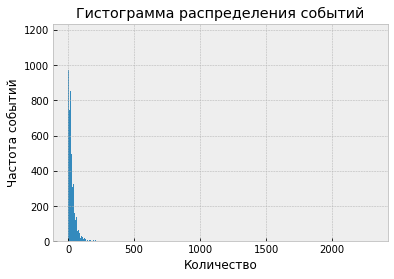

In [16]:
data.groupby('DeviceIDHash')['EventName'].count().hist(bins = 500)
plt.gca().set(title='Гистограмма распределения событий', xlabel='Количество', ylabel='Частота событий')
plt.show()

Распределение отлично от нормального, а следовательно наилучшей мерой среднего для нас является мода или медиана.

In [17]:
print('Медиана количества событий в среднем на пользователя:', data.groupby('DeviceIDHash')['EventName'].count().median())

Медиана количества событий в среднем на пользователя: 20.0


Пользователь может совершить несколько событий за сессию или за несколько сессий. Например, несколько раз просмотреть предложения.

## Период данных

In [18]:
print('Данные лежат в диапазоне дат:', data['date'].min(), '-', data['date'].max())

Данные лежат в диапазоне дат: 2019-07-25 00:00:00 - 2019-08-07 00:00:00


C:\Users\Anton.Dovgan\Documents\praktikum\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



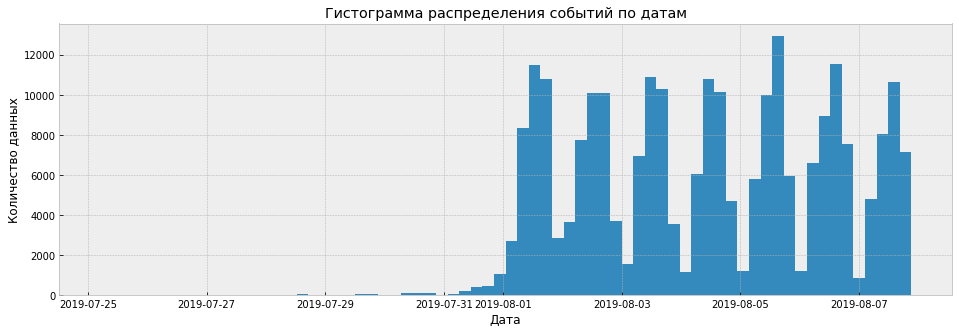

In [19]:
plt.figure(figsize=(16,5))
data['EventTimestamp'].hist(bins = 70) 
plt.gca().set(title='Гистограмма распределения событий по датам', xlabel='Дата', ylabel='Количество данных')
plt.show()

In [20]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId,date,time
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42


**Вывод:**    
отсекаем данные младше 2019-08-01, так как они являются не полными.

### Отсечение неполных данных

In [21]:
data_log = data.query('date >="2019-08-01"')

In [22]:
# Много ли событий и пользователей вы потеряли, отбросив старые данные?
print('В результате удаления,\nпотеряли событий = {lost_ec} шт. или {lost_ep:.2%}\nпользователей = {lost_uc} шт. или {lost_up:.2%}'
      .format(lost_ec = data.shape[0] - data_log.shape[0], 
              lost_ep = 1-(data_log.shape[0]/data.shape[0]), 
              lost_uc = data['DeviceIDHash'].nunique() - data_log['DeviceIDHash'].nunique(),
              lost_up = 1-(data_log['DeviceIDHash'].nunique()/data['DeviceIDHash'].nunique())))

В результате удаления,
потеряли событий = 2826 шт. или 1.16%
пользователей = 17 шт. или 0.23%


### Проверка пользователей в группах

#### Количество уникальных групп

In [23]:
print('Количесво уникальных групп =', data_log['ExpId'].nunique(), 'шт.')

Количесво уникальных групп = 3 шт.


#### Количество уникальных пользователей по группам

In [24]:
data_count_user = data_log.pivot_table(index = 'DeviceIDHash', values = 'ExpId', aggfunc={'nunique'}).reset_index()
data_count_user = data_log.groupby('ExpId')['DeviceIDHash'].nunique().reset_index()
data_count_user.columns = 'GroupId', 'UserCount'
data_count_user

,GroupId,UserCount
0,246,2484
1,247,2513
2,248,2537


# Воронка событий

## Наличие и количесво событий

In [25]:
event_stat_new = data_log.groupby('EventName')['DeviceIDHash'].count().reset_index()
event_stat_new.columns = 'EventName', 'Amount'
event_stat_new.sort_values(by='Amount', ascending = False)

,EventName,Amount
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


## Воронка     
Узнаем сколько пользователей совершили каждое событие.

In [26]:
user_count = data_log.pivot_table(index = ['EventName'], values = 'DeviceIDHash', aggfunc = {'nunique','count'}).reset_index()
user_count.columns = 'EventName', 'EventCount', 'UserCount'
# Посчитаем долю пользователей, которые хоть раз совершали событие
user_count['UserRate, %'] = ((user_count['UserCount']/data_log['DeviceIDHash'].nunique())*100).astype('int')
# Сортируем и выводим на экран
user_count.sort_values(by = 'UserCount', ascending = False, inplace=True)
user_count

,EventName,EventCount,UserCount,"UserRate, %"
1,MainScreenAppear,117328,7419,98
2,OffersScreenAppear,46333,4593,60
0,CartScreenAppear,42303,3734,49
3,PaymentScreenSuccessful,33918,3539,46
4,Tutorial,1005,840,11


'MainScreenAppear' = 98%, связано с тем, что пользоватли могли обойти данный этап.

## Визуальная воронка

In [27]:
fig = go.Figure(
    go.Funnel(
        y=user_count['EventName'],
        x=user_count['UserCount'],
    textposition = "inside",
    textinfo = "value+percent initial",
    )
)
fig.update_layout(title='Воронка событий с долей пользователей, переходящих на следующий шаг', yaxis_title="Названия событий")

fig.show() 

**Вывод:**     
Процент потерянных корзин очень мал, всего 5.2%, 47% пользователей от общего числа, доходят до оплаты. Больше всех пользователей теряется после просмотра "MainScreenAppear" 38%, т.е на 'OffersScreenAppear' переходит 62%.

А туториал смотрят всего 11% от общего числа пользователей.

## Последовательность событий    
MainScreenAppear => OffersScreenAppear => CartScreenAppear => PaymentScreenSuccessful. <br>
Tutorial не входит в воронку, так как наша основная цель, это довести пользователя до оплаты. Какой на самом деле контент находиться в данном разделе, нам не известно. Возможно там обучение по оформлению заказа или по приготовлению чего-либо. Это вторая причина, почему мы отклоняем этот этап.

## Наличие пользователей в группах

In [28]:
user_count_group = data_log.pivot_table(index = ['EventName'], values = 'DeviceIDHash', columns = 'ExpId', aggfunc = {'nunique'}).reset_index()
user_count_group.columns = 'EventName', '246', '247' , '248'
user_count_group.sort_values(by=['246'], ascending = False, inplace = True)
user_count_group

,EventName,246,247,248
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
0,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


## Воронока по группам

In [29]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Группа 246',
    y = user_count_group['EventName'],
    x = user_count_group['246'],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'Группа 247',
    y = user_count_group['EventName'],
    x = user_count_group['247'],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'Группа 248',
    y = user_count_group['EventName'],
    x = user_count_group['248'],
    textinfo = "value+percent initial"))

fig.update_layout(title='Воронка событий с долей пользователей, переходящих на следующий шаг', yaxis_title="Названия событий")

fig.show()

**Вывод:**    
Группа 246 на данный момент выглядит немного лучше, например в оплату переходит на 2% больше, чем в других группах.
Также во всех группах наблюдается одинаковая тенденция, а именно большинство пользователей "отваливается" на этапе 'MainScreenAppear', т.е примерно всего 62% пользователей переходит на этап 'OffersScreenAppear' и всего 2% не переходит с этапа 'CartScreenAppear' на 'PaymentScreenSuccessful'. 

Глобально от первого события до успешной оплаты доходит примерно 48%.

# Результаты эксперимента

## Количесво пользователей в группах

In [30]:
data_count_user = data_log.pivot_table(index = 'DeviceIDHash', values = 'ExpId', aggfunc={'nunique'}).reset_index()
data_count_user

,DeviceIDHash,nunique
0,6888746892508752,1
1,6909561520679493,1
2,6922444491712477,1
3,7435777799948366,1
4,7702139951469979,1
...,...,...
7529,9217594193087726423,1
7530,9219463515465815368,1
7531,9220879493065341500,1
7532,9221926045299980007,1


In [31]:
data_count_user = data_log.groupby('ExpId')['DeviceIDHash'].nunique().reset_index()
data_count_user.columns = 'GroupId', 'UserCount'
data_count_user

,GroupId,UserCount
0,246,2484
1,247,2513
2,248,2537


246 = 2484 пользователей;    
247 = 2513 пользователей;    
248 = 2537 пользователей.    
Группы различаются, но не значительно.

## Функция проверки гипотезы методом Фишера (z-test).

In [32]:
def z_test(data_1, data_2, group_1, group_2):
    alpha =.05

    # пропорция успеха в первой группе
    p1 = data_1/group_1
    # пропорция успеха во второй группе
    p2 = data_2/group_2

    # пропорция успехов в комбинированном датасете:
    p_combined = (data_1 + data_2) / (group_1 + group_1)

    # разница пропорций в датасетах
    difference = p1 - p2

    # статистика в ст.отклонениях стандартного нормального распределение
    z_value = difference / mth.sqrt(p_combined *(1 - p_combined) * (1/group_1 + 1/group_2))

    # укажем стандартное нормальное распределение (среднее 0, ст. отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(z_value)) * 2

    print('p-значение: ', p_value)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу:\nразница в долях пользователей экспериментальных групп статистически не значима.")
    else:
        print("Не получилось отвергнуть нулевую гипотезу,\nразница в долях пользователей экспериментальных групп статистически не значима.")

## А/А-тест по группам 246 и 247    
Выполним сравнение события MainScreenAppear между группами, в которых: 
    
H<sub>0</sub> - разница в долях пользователей экспериментальных групп статистически не значима.

H<sub>1</sub> - разница в долях пользователей экспериментальных групп статистически значима.   

α  = 0.05

In [33]:
z_test(user_count_group.iloc[0]['246'],
                 user_count_group.iloc[0]['247'],
                 data_count_user.iloc[0]['UserCount'],
                 data_count_user.iloc[1]['UserCount'],
                )

p-значение:  0.6892523366167316
Не получилось отвергнуть нулевую гипотезу,
разница в долях пользователей экспериментальных групп статистически не значима.


In [34]:
user_count_group

,EventName,246,247,248
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
0,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


## Популярное событие

In [35]:
user_count_group

,EventName,246,247,248
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
0,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


Популярное событие 'MainScreenAppear'. Данное событие выполнено:     
гр.246 - 2450       
гр.247 - 2476         
гр 248 - 2493

## Количество пользователей в группе

In [36]:
data_count_user

,GroupId,UserCount
0,246,2484
1,247,2513
2,248,2537


## Расчёт долей пользователей в группе

In [37]:
user_count_group['rate 246, %'] =  round(user_count_group['246'] / data_count_user.iloc[0]['UserCount'], 2)
user_count_group['rate 247, %'] =  round(user_count_group['247'] / data_count_user.iloc[1]['UserCount'], 2)
user_count_group['rate 248, %'] =  round(user_count_group['248'] / data_count_user.iloc[2]['UserCount'], 2)
user_count_group

,EventName,246,247,248,"rate 246, %","rate 247, %","rate 248, %"
1,MainScreenAppear,2450,2476,2493,0.99,0.99,0.98
2,OffersScreenAppear,1542,1520,1531,0.62,0.60,0.60
0,CartScreenAppear,1266,1238,1230,0.51,0.49,0.48
3,PaymentScreenSuccessful,1200,1158,1181,0.48,0.46,0.47
4,Tutorial,278,283,279,0.11,0.11,0.11


**Вывод:**     
доли почти равны.

## Z-Test

## A/A и A/B-тест - 'MainScreenAppear'

### Группы: 246, 247

In [38]:
z_test(user_count_group.iloc[0]['246'],
                 user_count_group.iloc[0]['247'],
                 data_count_user.iloc[0]['UserCount'],
                 data_count_user.iloc[1]['UserCount'],
                )

p-значение:  0.6892523366167316
Не получилось отвергнуть нулевую гипотезу,
разница в долях пользователей экспериментальных групп статистически не значима.


### Группы: 246, 248

In [39]:
z_test(user_count_group.iloc[0]['246'],
                 user_count_group.iloc[0]['248'],
                 data_count_user.iloc[0]['UserCount'],
                 data_count_user.iloc[2]['UserCount'],
                )

p-значение:  0.0672002846378863
Не получилось отвергнуть нулевую гипотезу,
разница в долях пользователей экспериментальных групп статистически не значима.


### Группы: 247, 248

In [40]:
z_test(user_count_group.iloc[0]['247'],
                 user_count_group.iloc[0]['248'],
                 data_count_user.iloc[1]['UserCount'],
                 data_count_user.iloc[2]['UserCount'],
                )

p-значение:  0.37934201817586866
Не получилось отвергнуть нулевую гипотезу,
разница в долях пользователей экспериментальных групп статистически не значима.


### Группы: 246+247, 248

In [41]:
z_test((user_count_group.iloc[0]['246'] + user_count_group.iloc[0]['247']),
                 user_count_group.iloc[0]['248'],
                 data_count_user.iloc[0]['UserCount'] + data_count_user.iloc[1]['UserCount'],
                 data_count_user.iloc[2]['UserCount'],
                )

p-значение:  0.7687362863210951
Не получилось отвергнуть нулевую гипотезу,
разница в долях пользователей экспериментальных групп статистически не значима.


**Вывод:** z-test показывает, что нет оснований считать доли разными. Глобально принимаем гипотезу H<sub>0</sub>

## A/A и A/B-тест - 'OffersScreenAppear'

### Группы: 246, 247

In [42]:
z_test(user_count_group.iloc[1]['246'],
                 user_count_group.iloc[1]['247'],
                 data_count_user.iloc[0]['UserCount'],
                 data_count_user.iloc[1]['UserCount'],
                )

p-значение:  0.24727749816441724
Не получилось отвергнуть нулевую гипотезу,
разница в долях пользователей экспериментальных групп статистически не значима.


### Группы: 246, 248

In [43]:
z_test(user_count_group.iloc[1]['246'],
                 user_count_group.iloc[1]['248'],
                 data_count_user.iloc[0]['UserCount'],
                 data_count_user.iloc[2]['UserCount'],
                )

p-значение:  0.2069165034814664
Не получилось отвергнуть нулевую гипотезу,
разница в долях пользователей экспериментальных групп статистически не значима.


### Группы: 247, 248

In [44]:
z_test(user_count_group.iloc[1]['247'],
                 user_count_group.iloc[1]['248'],
                 data_count_user.iloc[1]['UserCount'],
                 data_count_user.iloc[2]['UserCount'],
                )

p-значение:  0.9196797438130537
Не получилось отвергнуть нулевую гипотезу,
разница в долях пользователей экспериментальных групп статистически не значима.


### Группы: 246+247, 248

In [45]:
z_test((user_count_group.iloc[1]['246'] + user_count_group.iloc[1]['247']),
                 user_count_group.iloc[1]['248'],
                 data_count_user.iloc[0]['UserCount'] + data_count_user.iloc[1]['UserCount'],
                 data_count_user.iloc[2]['UserCount'],
                )

p-значение:  0.4440294319831386
Не получилось отвергнуть нулевую гипотезу,
разница в долях пользователей экспериментальных групп статистически не значима.


**Вывод:** z-test показывает, что нет оснований считать доли разными. Глобально принимаем гипотезу H<sub>0</sub>

## A/A и A/B-тест - 'CartScreenAppear'

### Группы: 246, 247

In [46]:
z_test(user_count_group.iloc[2]['246'],
                 user_count_group.iloc[2]['247'],
                 data_count_user.iloc[0]['UserCount'],
                 data_count_user.iloc[1]['UserCount'],
                )

p-значение:  0.2288197623317827
Не получилось отвергнуть нулевую гипотезу,
разница в долях пользователей экспериментальных групп статистически не значима.


### Группы: 246, 248

In [47]:
z_test(user_count_group.iloc[2]['246'],
                 user_count_group.iloc[2]['248'],
                 data_count_user.iloc[0]['UserCount'],
                 data_count_user.iloc[2]['UserCount'],
                )

p-значение:  0.07843072791160144
Не получилось отвергнуть нулевую гипотезу,
разница в долях пользователей экспериментальных групп статистически не значима.


### Группы: 247, 248

In [48]:
z_test(user_count_group.iloc[2]['247'],
                 user_count_group.iloc[2]['248'],
                 data_count_user.iloc[1]['UserCount'],
                 data_count_user.iloc[2]['UserCount'],
                )

p-значение:  0.5786556822269917
Не получилось отвергнуть нулевую гипотезу,
разница в долях пользователей экспериментальных групп статистически не значима.


### Группы: 246+247, 248

In [49]:
z_test((user_count_group.iloc[2]['246'] + user_count_group.iloc[2]['247']),
                 user_count_group.iloc[2]['248'],
                 data_count_user.iloc[0]['UserCount'] + data_count_user.iloc[1]['UserCount'],
                 data_count_user.iloc[2]['UserCount'],
                )

p-значение:  0.16755002057756174
Не получилось отвергнуть нулевую гипотезу,
разница в долях пользователей экспериментальных групп статистически не значима.


**Вывод:** z-test показывает, что нет оснований считать доли разными. Глобально принимаем гипотезу H<sub>0</sub>

## A/A и A/B-тест - 'PaymentScreenSuccessful'

### Группы: 246, 247

In [50]:
z_test(user_count_group.iloc[3]['246'],
                 user_count_group.iloc[3]['247'],
                 data_count_user.iloc[0]['UserCount'],
                 data_count_user.iloc[1]['UserCount'],
                )

p-значение:  0.11467393093464251
Не получилось отвергнуть нулевую гипотезу,
разница в долях пользователей экспериментальных групп статистически не значима.


### Группы: 246, 248

In [51]:
z_test(user_count_group.iloc[3]['246'],
                 user_count_group.iloc[3]['248'],
                 data_count_user.iloc[0]['UserCount'],
                 data_count_user.iloc[2]['UserCount'],
                )

p-значение:  0.21247102681031782
Не получилось отвергнуть нулевую гипотезу,
разница в долях пользователей экспериментальных групп статистически не значима.


### Группы: 247, 248

In [52]:
z_test(user_count_group.iloc[3]['247'],
                 user_count_group.iloc[3]['248'],
                 data_count_user.iloc[1]['UserCount'],
                 data_count_user.iloc[2]['UserCount'],
                )

p-значение:  1.2625781454033826
Не получилось отвергнуть нулевую гипотезу,
разница в долях пользователей экспериментальных групп статистически не значима.


### Группы: 246+247, 248

In [53]:
z_test((user_count_group.iloc[3]['246'] + user_count_group.iloc[3]['247']),
                 user_count_group.iloc[3]['248'],
                 data_count_user.iloc[0]['UserCount'] + data_count_user.iloc[1]['UserCount'],
                 data_count_user.iloc[2]['UserCount'],
                )

p-значение:  0.5846485274549968
Не получилось отвергнуть нулевую гипотезу,
разница в долях пользователей экспериментальных групп статистически не значима.


**Вывод:** z-test показывает, что нет оснований считать доли разными. Глобально принимаем гипотезу H<sub>0</sub>. Поэтому нет коммерческого смысла вносить предложенные изменения в продукт, так как это не оказывает ни какого влияния активность пользователей. 

В ходе теста также был применён уровень значимости 0.1. При использовании данного уровня, увеличивается вероятность того, что мы отвергнем гипозезу H<sub>0</sub>, соответсвенно увеличивается вероятность ошибки первого рода. Поэтому оставляем α  = 0.05.

# Общий вывод

## Выполненные работы:    
1. изучение документа;    
2. поиск и удаление дубликатов, в размере 413 шт.;     
3. перекодирование формата времени из unix формата;
4. построена и проанализирована воронка;
5. выполнен z-тест.
    
## Содержание лога    
  - 7551 пользователь;
  - 5 событий;
  - 3 группы;
  - на одного пользователя в среднем приходиться 32 события;
  - были удалены неполные данные. После удаления лог содержит данные от 08-01-2019 включительно.

## Воронка
Согласно воронке, около 62% переходит на шаг 'OffersScreenAppear', остальные 38% покидают приложение. Это самая крупная часть по отказу пользователей.     
В остальном пользователи ведут себя предсказуемо: выбрали продукт, положили его в корзину, оформили и оплатили. 
До оплаты доходит 48% от всех пользователей.
Т.е имеется очень низкий % брошенных корзин, приблизительно равный 5%, от оплаченных заказов.

Туториал просматривают не часто, но это не критично. Но если мы продаём технику, то конечно это может повлиять на количество обращений в сервисный центр.
  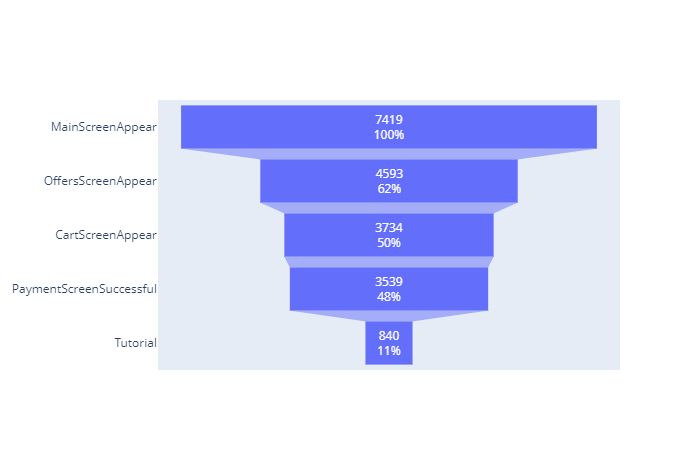
  
## Z-тест(критерий Фишера)
- проведены попарные сравнения, включая с объединённой контрольной группой.
- проведённые тесты не показали разницы между контрольными группами, а значит выполненные изменения не повлияют на активность пользователей, а команда не улучшит свои показатели. Глобально принимаем гипотезу H0.

## Рекомендации
Стоит обратить внимание на первый и второй этап воронки, так как именно на данных этапах происходит наибольший отказ со стороны пользователей. На данный момент он более 20%, а это значит что ситуация там критическая и требует скорейшей корректировки.